# Natural Language Processing: 

## Jargon/Codeword Comprehension with Word2Vec

### Problem:

This problem comes to us from a data analyst for a national truck-stop chain.  His team was spending a great deal of time and effort trying to comprehend local jargon that they were receiving through a reporting application.  An example of this is the myriad of words used for "compressor." In the lexicon at any given truck stop, this word could be replaced with the brand name of the compressor, even in light of the fact that the brand might make products other than compressors, or nicknames such as "skid."  Occurences such as these cost the data analyst's team countless hours of effort trying to comprehend, for instance, basic requests for parts.

It would be nice to have a thesaurus of truck-stop terminology on hand, but it is unlikely Roget's has gotten around to that yet.  Fortunately, deep learning has an answer.  In this notebook, we'll walk through the process of creating word embeddings from a messy, domain specific corpus (in this case medical call center text from [here](https://www.kaggle.com/jsreddy79/text-classification-supervised-learning#TextClassification_Data.csv)). This will allow us to create, for all intents and purposes, a thesaurus specific to a given working environment for the purpose of jargon comprehension.  The data preprocessing necessary to execute the method is minimal and the results are quite good even though the dataset could best be described as messy and small (as one would expect to encounter when dealing with such a problem). 

### Method:

We use a modified Word2Vec skip-gram algorithm to create the embeddings. Word2Vec is a trusted and flexible method for the creation of word embeddings, modified here in two key ways.  First, for the purpose of noise reduction when creating the training data from the corpus, an end token is added to acknowledge the short phrases on which the embeddings are trained.  Secondly, since the corpus is small, we implement a progressive parametrized subsampling scheme so that at the beginning of the training process all words are being trained, but by the end, only half are being trained. This was implemented after it became apparent that the small size of the corpus caused the probabalistic subsampling scheme to become deterministic (many passes through the corpus and the Law of Large Numbers). The implementation of the progressive scheme improved results dramatically.  

### Other Applications:

This method can be used in any environment where jargon comprehension is an issue. An oilfield services company might experience the same problem as the truck-stop data analyst, or hospitals sharing information might run into this difficulty as well. This method might also help market researchers understand slang specific to a region and therefore allow them to communicate more effectively with regional customer bases. A more exciting application might be code-word understanding.

#### NLP for Law Enforcement/Counterterrorism:

It is common among criminal and terrorist organizations to speak in code. For example, a terrorist wouldn't write on a communications platform "please have the bomb ready for me by Friday at 2PM for the attack," he/she would likely replace some key words like "bomb" and "attack" with innocuous terms like "cake" and "party" respectively. It is likely that building word embeddings from communications data collected from a terrorist network and checking similiarity with previously known code words would aid intelligence analysts in cracking those codes. This wouldn't just apply to terrorists of course; the communications of drug cartels and gangs would also be targets for this approach. 

### Additional Features:

We also implement parts-of-speech quantization using the NLTK package and k-means clustering. This is a proposed feature engineering technique in case the embeddings are to be used in, for example, a classification problem. Essentially, we create a quantized dictionary that maps similar nouns to one representative vector. We only do this for nouns, but it can be done with any part of speech detectable by NLTK's parts of speech classifier. This technique is proposed as a way to aid the task of optimization in a machine learning task, deep learning or otherwise. 

#### On to the code. 

## Module import block:

In [1]:
import pandas as pd
import csv
import collections
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import random
import math
import string
import itertools
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time
import copy
import datetime
from tempfile import TemporaryFile
import nltk

## Data import/preprocessing:

As usual, we use Pandas to import and clean our dataset. 

In [2]:
pre_data = pd.read_csv('Text_Class_Prototype//TextClassification_Data.csv', encoding = "ISO-8859-1")
pre_data.head()

,fileid,SUMMARY,DATA,categories,sub_categories,previous_appointment,ID
0,2015561331001,Pt aware that he needs ROV for refill,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,PRESCRIPTION,REFILL,No,2015_5_6133_1001
1,2015561341001,Mom wants to know if the Focalin needs some do...,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6134_1001
2,2015561351001,pt called to discuss nortryptiline. she says s...,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6135_1001
3,2015561361001,FYI Nortryptline medication.,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,MISCELLANEOUS,OTHERS,No,2015_5_6136_1001
4,2015561371001,Letter of patient establishment request,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,MISCELLANEOUS,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",No,2015_5_6137_1001


In [3]:
pre_data = pre_data[['SUMMARY', 'categories']].dropna()
pre_data.head()

,SUMMARY,categories
0,Pt aware that he needs ROV for refill,PRESCRIPTION
1,Mom wants to know if the Focalin needs some do...,ASK_A_DOCTOR
2,pt called to discuss nortryptiline. she says s...,ASK_A_DOCTOR
3,FYI Nortryptline medication.,MISCELLANEOUS
4,Letter of patient establishment request,MISCELLANEOUS


In [4]:
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11743, 'MISCELLANEOUS': 10460, 'LAB': 4246, 'JUNK': 20, 'mISCELLANEOUS': 3, 'asK_A_DOCTOR': 1})


In [5]:
def fix(data_frame):
    junk_list = list(data_frame[data_frame['categories'] == 'JUNK'].index)
    data_frame = data_frame.drop(junk_list, axis = 0)
    data_frame = data_frame.replace(['mISCELLANEOUS', 'asK_A_DOCTOR'], ['MISCELLANEOUS','ASK_A_DOCTOR'])
    return data_frame

pre_data = fix(pre_data)
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11744, 'MISCELLANEOUS': 10463, 'LAB': 4246})


In [6]:
data_array = pre_data.values[...,0]

## Corpus Construction:

The embedding task requires the following:

1. A *list of words* in order with the end of phrases marked with an end token. Note: another container type like a queue might be more efficient (i.e. things are done in order so a complete indexing of the corpus is unecessary), but no issues were encountered. 
2. A *dictionary* that maps each word to an integer; in this case, the integer is chosen by occurence rank with ties broken randomly. 
3. A *reverse dictionary* that maps the numbers back to words.
4. A *frequency dictionary* that records the word's actual frequency in the corpus (for subsampling).

The following block creates these after processing each string to separate out punctuation and measurements.

In [7]:
stop_list = [".",",","!","?",":",";","/","(",")","-", "\ufeff", "\"", "\'s"]
measurements = ["mg", "cc", "lb", "lbs", "kg", "kgs"]
end_signature = '[..end..]'

def format_string(string):
    global stop_list
    global measurements
    for item in stop_list:
        string = string.replace(item, " " + item + " ")
    for item in measurements:
        if item in string:
            index = string.find(item)
            if ord(string[index - 1]) in range(48,58):
                string = string[:index] + " " + string[index:]
    return string.lower()

def strings2list(column, report = True, n_most_common = 20):
    # input: 1D numpy array of strings.
    # output: list of words, spaced punctuation, and end token.
    global end_signature
    out_list = []
    for i in range(column.shape[0]):
        if isinstance(column[i], str):
            instance_list = format_string(column[i]).split() + [end_signature]
            out_list = out_list + instance_list
        else:
            print('Entry not a string at index ' + str(i))
    frequency_dictionary = collections.Counter(out_list)
    dictionary = dict()
    for word, _ in frequency_dictionary.most_common():
        dictionary[word] = len(dictionary) 
    if report:
        print(str(len(out_list)) + " instances across " + str(len(frequency_dictionary)) + " distinct.")
        print("%d most common words: " % n_most_common, end = "")
        print(dict(frequency_dictionary.most_common(n_most_common)))
    reverse_dictionary = dict(zip(dict(dictionary).values(), dict(dictionary).keys()))
    return out_list, dictionary, reverse_dictionary, dict(frequency_dictionary)

words_list, dictionary, reverse_dictionary, frequency_dictionary = strings2list(data_array, n_most_common = 100)

405324 instances across 10763 distinct.
100 most common words: {'[..end..]': 53913, '/': 17386, 'to': 11495, 'pt': 10690, 'rx': 8680, '-': 8090, '.': 6604, ',': 5607, 'for': 5495, 'appt': 4623, ':': 4588, 'phone': 3945, 'note': 3892, 'request': 3866, 'refill': 3705, 'on': 3414, 'call': 3149, '15': 3095, 'with': 3043, 'and': 2931, 'mri': 2802, 'in': 2454, 'rov': 2298, 'a': 2132, 'results': 2130, 'dr': 2029, "'s": 1982, 'of': 1925, 'please': 1799, 'mom': 1636, 'the': 1569, '?': 1559, 'clld': 1550, 'from': 1473, 'scheduled': 1419, 'w': 1391, 'order': 1386, 'needs': 1356, 'called': 1346, 'about': 1345, '1': 1326, 'patient': 1305, '2015': 1274, 'new': 1255, 'is': 1238, '2': 1219, 'rn': 1210, 'calling': 1175, '3': 1171, 'at': 1168, 'like': 1145, 'would': 1117, 'add': 1105, '@': 1099, 'pa': 1067, 'work': 1054, 'wants': 1035, 'today': 1025, 'requesting': 997, 'not': 991, 'need': 965, 'sch': 944, 'discuss': 938, 'pls': 924, 'mg': 924, '6': 923, '4': 922, 'referral': 914, '5': 900, 'cb': 898, 'r

## Encoded corpus:

We encode the corpus by frequency indexed high to low using the dictionary created above. This encoding will refer to the row-vector index in the embedding matrix associated to that word from initialization onward. 

In [8]:
numerically_encoded_corpus = [dictionary[word] for word in words_list]

# Example of encoding:

for number in numerically_encoded_corpus[:20]:
    print(str(number), end = " ")
print(" ")
for number in numerically_encoded_corpus[:20]:
    print(reverse_dictionary[number], end = " ")
del words_list

3 493 159 209 37 22 8 14 0 29 56 2 167 118 30 290 37 629 355 3814 0 3 38 2 62 2498 6 98 172 98 72 23 3139 5243 0 85 5244 101 6 0 89 27 41 5245 13 0 9 127 0 1057 81 1408 605 686 330 946 256 356 0 28 509 2139 36 2 43 2499 130 216 74 3140 0 3 56 2 301 1567 33 150 1 83 7 28 16 0 11 12 0 22 0 28 367 2736 19 36 5246 5247 1515 6 0 3  
pt aware that he needs rov for refill [..end..] mom wants to know if the focalin needs some dosage adjusting [..end..] pt called to discuss nortryptiline . she says she has a weird tas [..end..] fyi nortryptline medication . [..end..] letter of patient establishment request [..end..] appt question [..end..] dizzy & double vision past 45 mins after ct [..end..] please refax neurocog order to new fac ; wake med maybe [..end..] pt wants to reschedule epidural from 04 / 30 , please call [..end..] phone note [..end..] rov [..end..] please go ahead and order mandibular repositioning device . [..end..] pt 

## Word2Vec: End-Acknowledging Skip-gram

### Batch generator:

The batch generator handles the subsampling, that is, the words not to train after having been seen enough. The function we use to determine subsampling is $$\left(\sqrt{\frac{f}{\rho}}+1\right)*\frac{\rho}{f}$$ where $\rho$ is a parameter and $f$ is the frequency ratio of the word (number of times occurred/all occurences of words) [(taken from here)](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/). A higher $\rho$ means a higher keep probability.

The end acknowledgement is handled by looking left and then right of the word to be trained, stopping either process when an end token is seen.

In [9]:
data_index = 0
left_right_index = [0,0]
subsample_words = []

def subsample_keep_probability(frequency_ratio, parameter = 0.01):
    return min(1, (math.sqrt(frequency_ratio/parameter)+1)*parameter/frequency_ratio)

def generate_batch_end_acknowledging_skipgram(corpus, 
                                              batch_size = None, 
                                              n_left = 2, 
                                              n_right = 2,
                                              subsample = True,
                                              subsample_parameter = 0.01):
    global end_signature
    global data_index
    global left_right_index
    global subsample_words
    corpus_size = len(corpus)
    assert isinstance(batch_size, int), "Batch Generator: You must specify a batch size."
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    record_position = 0
    word_recorded = False
    corpus_size = len(corpus)
    while record_position < batch_size:
        if subsample and corpus[data_index] in subsample_words:
            data_index = (data_index + 1) % corpus_size
            continue
        
        if corpus[data_index] == dictionary[end_signature]:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
            data_index = (data_index + 1) % corpus_size
            word_recorded = False
            continue
            
        for i in range(left_right_index[0], n_left):
            if record_position == batch_size:
                break
            if corpus[data_index - 1 - i] == dictionary[end_signature]:
                break
            if subsample == True and corpus[data_index-1-i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index - 1 - i]
                word_recorded = True
                left_right_index[0] += 1
                record_position += 1
                
        for i in range(left_right_index[1], n_right):
            if record_position == batch_size:
                break
            if corpus[data_index + 1 + i] == dictionary[end_signature]:
                break
            if subsample and corpus[data_index+1+i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index + 1 + i]
                word_recorded = True
                left_right_index[1] += 1
                record_position += 1
                 
        if not word_recorded:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
        if record_position == batch_size:
            break

        if subsample:
            frequency_ratio = frequency_dictionary[reverse_dictionary[corpus[data_index]]]/corpus_size 
            probability = subsample_keep_probability(frequency_ratio, parameter = subsample_parameter)
            sample = random.uniform(0,1)
            if sample > probability:
                subsample_words.append(corpus[data_index])
        data_index = (data_index + 1) % corpus_size
        word_recorded = False
        left_right_index = [0,0]
    return batch, labels

example_batch, example_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus, 
                                                                          batch_size = 12)
print("Example Text:")
for i in range(10):
    print(reverse_dictionary[numerically_encoded_corpus[i]], end = " ")
print(" ")
print("Example Numerical Word Pairs:")
print(example_batch)
print(example_labels)
print("Example Word Pairs:")
print('Batch 1: ', end = "")
print([reverse_dictionary[x] for x in example_batch])
print('Label 1: ', end = "")
print([reverse_dictionary[x] for x in example_labels.reshape(12)])

pt aware that he needs rov for refill [..end..] mom  
[  3   3 493 493 493 159 159 159 159 209 209 209]
[[493]
 [159]
 [  3]
 [159]
 [209]
 [493]
 [  3]
 [209]
 [ 37]
 [159]
 [493]
 [ 37]]
Batch 1: ['pt', 'pt', 'aware', 'aware', 'aware', 'that', 'that', 'that', 'that', 'he', 'he', 'he']
Label 1: ['aware', 'that', 'pt', 'that', 'he', 'aware', 'pt', 'he', 'needs', 'that', 'aware', 'needs']


### TensorFlow Embedding Graph:

Note: The warning is likely due to a dependency in either the `tf.nn.embedding_lookup` function or the `tf.nn.sampled_softmax_loss` function. This will likely dissappear in updated versions of TensorFlow, as these functions are not deprecated themselves and the dependency should have been updated.  

We choose an embedding dimension of 128, which will result in 127 degrees of freedom for meaning to be encoded after normalization (see Similarity Search).

In [10]:
vocabulary_size = len(dictionary)
embedding_size = 128
number_negative_samples = 64
batch_size = 128

Word2VecSG_graph = tf.Graph()

with Word2VecSG_graph.as_default():
    # Input: Integer indices of rows to look up. 
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size,1])
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],
                                               minval = -1.0,
                                               maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev = 1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                               biases=softmax_biases, 
                               inputs=embed,
                               labels=train_labels, 
                               num_sampled=number_negative_samples, 
                               num_classes=vocabulary_size)
    
    loss = tf.reduce_mean(sampled_softmax_loss)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Normalized embeddings.
    embedding_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/embedding_norm

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


### Training Block:

We train by time and report by iterations. 

The progressive subsampling scheme is implemented by reducing the subsampling parameter by an order of magnitude after every 5 minutes of training. We start with no subsampling and progressively subsample more and more. 

In [12]:
training_time = 30 # minutes
report_frequency = 30000 # by iteration

# Clear subsampled words before each training session. 
subsample_words = []

# Start with no subsampling then subsample more as time passes. 
subsample_trigger = False
subsample_param = .1

with tf.Session(graph = Word2VecSG_graph) as session:
    start_time = time.time()
    run_time = 0
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    average_loss = 0
    iteration = 0
    checkpoint = [5., 10., 15., 20., 25., 30., 35.]
    checkpoint_index = 0
    while run_time < training_time*60:
        batch_data, batch_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus,
                                                                            batch_size = batch_size, 
                                                                            subsample = subsample_trigger,
                                                                            subsample_parameter = subsample_param)
        feed_dict = {train_data : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        run_time = time.time() - start_time
        average_loss += l
        if iteration % report_frequency == 0 and iteration > 0:
            average_loss = average_loss / report_frequency
            print('Average loss at iteration %d: %f' % (iteration, average_loss))
            print('Number of subsampled words: %d' % len(subsample_words))
            average_loss = 0
        iteration += 1
        if run_time/60 > checkpoint[checkpoint_index]:
            run_time_min = run_time/60
            print("Run time: %f minutes." % run_time_min)
            subsample_trigger = True
            subsample_param = subsample_param*.1
            print("Subsample Parameter: %f." % subsample_param)
            checkpoint_index += 1
    Word2Vec_embeddings = normalized_embeddings.eval()
    print('Embedding complete.')

Variables Initialized
Average loss at iteration 30000: 3.090946
Number of subsampled words: 0
Average loss at iteration 60000: 2.742075
Number of subsampled words: 0
Average loss at iteration 90000: 2.644080
Number of subsampled words: 0
Average loss at iteration 120000: 2.578989
Number of subsampled words: 0
Average loss at iteration 150000: 2.539021
Number of subsampled words: 0
Average loss at iteration 180000: 2.511851
Number of subsampled words: 0
Average loss at iteration 210000: 2.488385
Number of subsampled words: 0
Run time: 5.000020 minutes.
Subsample Parameter: 0.010000.
Average loss at iteration 240000: 2.445445
Number of subsampled words: 3
Average loss at iteration 270000: 2.235600
Number of subsampled words: 3
Average loss at iteration 300000: 2.215488
Number of subsampled words: 3
Average loss at iteration 330000: 2.204399
Number of subsampled words: 3
Average loss at iteration 360000: 2.194782
Number of subsampled words: 3
Average loss at iteration 390000: 2.188184
Num

#### Save Embeddings:

This code block saves the embeddings, which are just a NumPy matrix where the row vectors correspond to the words given by the dictionary. That is, if `dictionary[word] = n`, then `Word2Vec_embeddings[n] = vector representing word`.

In [14]:
def save_embeddings(embeddings):
    file_name = "Embed_" + str(datetime.datetime.now())[:19].replace(" ","_").replace(":",".")
    np.save(file_name, embeddings)
    file_name += ".npy"
    print("Embeddings saved as: " + file_name)
    return file_name
    
saved_array = save_embeddings(Word2Vec_embeddings)
loaded_embeddings = np.load(saved_array)

Embeddings saved as: Embed_2019-08-13_22.02.54.npy


In [15]:
# Test that embeddings saved correctly.
np.array_equal(loaded_embeddings, Word2Vec_embeddings)

True

## TSNE Visualization:

The visualization below is a clustered dimension reduction that begins with a principal component analysis.  Here we can see neighborhoods of relevant words, such as drug names, pharmacies, medical centers in North Carolina, and related symptoms and conditions; for example "migrane" and "ha" appear close to one another which means that most likely, when it appears in this context "ha" is an abbreviation for headache, which also appears in the neighborhood of those two words.

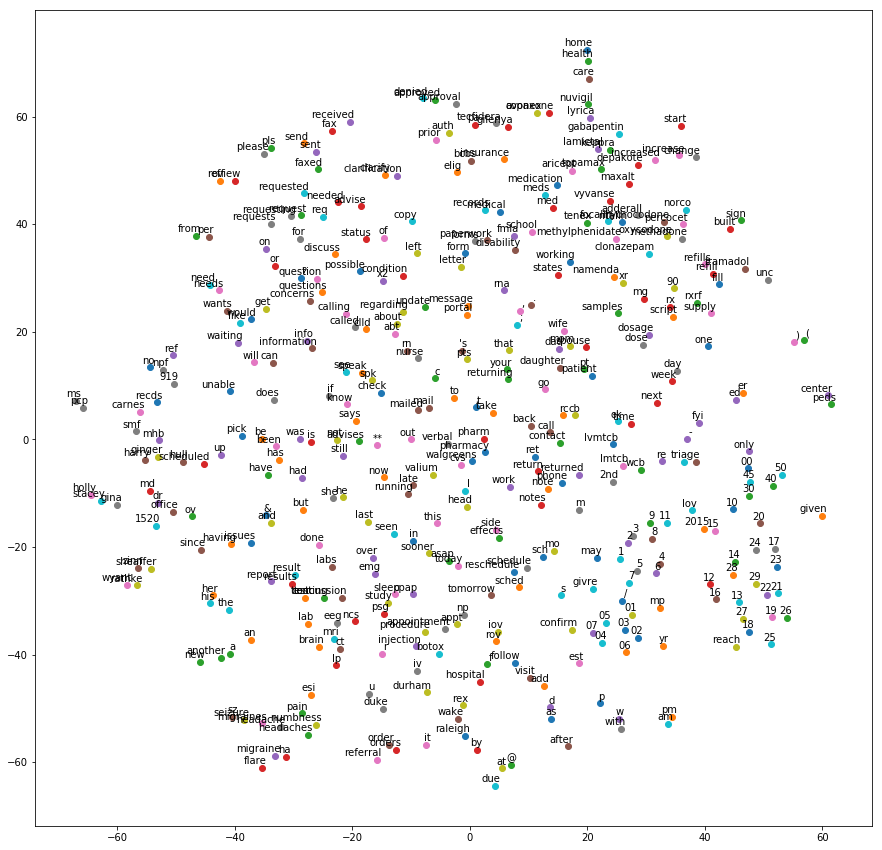

In [16]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(Word2Vec_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Similarity Search:

The nice thing about using normalized embeddings is that searching for similar word vectors is just a matter of a dot product.  This is beacuse in our case, all of the vectors lie on a sphere in 128 dimensions, so the measure of the distance between any two vectors is given in terms of the angle that they create.  Doing this loses exactly one degree of freedom, since the circle is locally a line, the surface of a sphere is locally a flat plane, etc., so there is still enough complexity to get good results.  Since the vectors lie on a hypersphere, the dot product of any two vectors is essentially the "cosine" of the angle they make (hence the frequently used term *cosine similarity*).

In [17]:
def sim_search(word, embeddings, n_nearest = 5):
    assert word in dictionary.keys(), "Word not in dictionary."
    vector = np.transpose(embeddings[dictionary[word]].reshape((1,128)))
    sim = np.matmul(embeddings, vector).reshape((vocabulary_size,))
    nearest = np.argsort(-sim)[1 : n_nearest + 1]
    print("Highest similarity to %s:" % word, end = " ")
    for i in range(len(nearest)-1):
        print(reverse_dictionary[nearest[i]], end = ", ")
    print(reverse_dictionary[nearest[-1]] + ".")

Below we demonstrate that the embedding vectors have vector norm 1. 

In [18]:
for i in range(10):
    print("Norm = %f" % np.linalg.norm(Word2Vec_embeddings[i]))

Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000
Norm = 1.000000


And below we run the similarity search on some common words. Some randomness still crops up, but the results show effective similarities in the context of our corpus. 

In [19]:
sim_search('paperwork', Word2Vec_embeddings)

Highest similarity to paperwork: forms, discrepancy, 556, expediting, original.


In [20]:
sim_search('mom', Word2Vec_embeddings)

Highest similarity to mom: dad, pt, grandmother, spouse, wife.


In [21]:
sim_search('sz', Word2Vec_embeddings)

Highest similarity to sz: szs, seizure, saturday, 20min, grandmal.


In [22]:
sim_search('rx', Word2Vec_embeddings)

Highest similarity to rx: script, candesartan, mg, chlordiazepoxide, flexeril.


In [23]:
sim_search('appt', Word2Vec_embeddings)

Highest similarity to appt: np, appointment, app, scheduled, appt>.


# NLTK POS Quantization: Feature Engineering for NLP Problems

The following feature engineering technique combines parts-of-speech tagging and k-means clustering to quantize (as one would quantize a noisy signal) the vocabulary represented by the word embeddings. The idea here is simple; in the best circumstances, the language used across authors would be uniform. A machine learning algorithm might benifit from the same uniformity while optimizing the parameters in a classification problem. 

Note: This can be executed for any word embeddings, Word2Vec or otherwise, where the distance metric of KMeans and your vector embeddings are meaningfully similar.  Also, we only quantize nouns here, but quantizing the dictionary for other parts of speech would be just as valid. 

##### Start by making the corpus a string to be handled by NLTK. 

In [24]:
text = ""
for i in range(len(numerically_encoded_corpus)):
    if numerically_encoded_corpus[i] != dictionary[end_signature]:
        text += " " + reverse_dictionary[numerically_encoded_corpus[i]]
    else:
        text += "."

##### Next we tag the text using the NLTK tagger. 

In [25]:
sample_text = text[:102]
print(sample_text)

 pt aware that he needs rov for refill. mom wants to know if the focalin needs some dosage adjusting. 


In [26]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hullj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hullj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
tagged_text = nltk.pos_tag(nltk.word_tokenize(text))
print(tagged_text[:21])

[('pt', 'NN'), ('aware', 'NN'), ('that', 'IN'), ('he', 'PRP'), ('needs', 'VBZ'), ('rov', 'NN'), ('for', 'IN'), ('refill', 'NN'), ('.', '.'), ('mom', 'NN'), ('wants', 'VBZ'), ('to', 'TO'), ('know', 'VB'), ('if', 'IN'), ('the', 'DT'), ('focalin', 'NN'), ('needs', 'VBZ'), ('some', 'DT'), ('dosage', 'NN'), ('adjusting', 'NN'), ('.', '.')]


##### Code an algorithm to decide what a noun is according to NLTK. 

Some words serve different functions by context, e.g. the word "mail" is a verb and a noun, and NLTK might mistag some words due to the messy nature of the text (see below "clld" which we can deduce from the TSNE visualization means "called"). We choose a threshold of 75%, i.e., if a word is tagged as a noun 75% of the time according to NLTK, then it is a noun for our purposes. The output is a list of the noun indices (row positions in the embedding matrix). 

In [28]:
def find_noun_indices(tagged_text, threshold = .75):
    global dictionary
    global frequency_dictionary
    noun_indices = []
    for key in [*dictionary][1:]:
        # List comprehension to gather tags for word.
        word_tags = [tag for (word, tag) in tagged_text if word == key]
        word_tag_fd = nltk.FreqDist(tag for tag in word_tags)
        noun_occurence = word_tag_fd['NN']
        total = frequency_dictionary[key]
        if noun_occurence/total > threshold:
            noun_indices.append(dictionary[key])
    return noun_indices

nouns = find_noun_indices(tagged_text)

print("%d nouns found." % len(nouns))
for i in range(100):
    print(reverse_dictionary[nouns[i]], end = ", ")

4150 nouns found.
pt, rx, phone, note, refill, mom, clld, order, rn, work, today, advise, hydrocodone, letter, pharmacy, pain, status, re, study, req, medication, triage, md, form, cpap, office, question, change, auth, mp, migraine, percocet, lvmtcb, pm, increase, oxycodone, side, home, test, ha, gabapentin, concussion, day, botox, tomorrow, school, m, gilenya, clarification, brain, rxrf, wife, l, vyvanse, tecfidera, script, time, ref, daughter, seizure, rc, pharm, insurance, spouse, approval, recds, esi, info, care, mo, result, message, hull, supply, headache, valium, dad, rathke, focalin, copaxone, disability, wyant, copy, flare, injection, paperwork, smf, bcbs, mail, procedure, methylphenidate, methadone, givre, hospital, ginger, health, review, dosage, npf, clonazepam, 

##### Use pandas to create a submatrix that keeps track of the nouns and their original positions in the embedding matrix. 

This could be done in NumPy, but using Pandas makes it easy and data frames play nice with the SciKit-Learn algorithms.  

In [29]:
embeddings_df = pd.DataFrame(data=Word2Vec_embeddings)
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.126074,0.027931,-0.087600,-0.060830,-0.088584,0.134468,-0.015887,0.060802,-0.123648,0.084555,...,-0.075835,0.101551,0.042050,-0.106045,0.049622,-0.091043,-0.120835,0.062259,-0.058011,0.068177
1,0.030458,0.105492,-0.042310,0.001044,-0.011342,-0.088055,-0.110638,-0.022793,-0.019762,0.518738,...,-0.023499,0.017461,-0.020016,0.003719,-0.073454,-0.030439,0.090093,0.014462,-0.041745,0.076970
2,0.009709,-0.060010,-0.067411,-0.018967,-0.096528,-0.339967,0.023067,0.147563,0.018108,0.307569,...,0.045537,-0.051349,0.124980,-0.024079,0.008101,-0.167918,-0.009063,-0.113746,-0.073188,-0.023154
3,-0.083789,0.028061,-0.017564,0.119852,-0.049593,0.078778,-0.006203,-0.053420,0.174603,0.105106,...,0.008724,0.033960,-0.120780,-0.017183,0.077757,-0.178741,-0.038747,-0.056440,0.064137,0.052549
4,-0.058221,-0.050996,0.109315,-0.024005,0.043083,0.031438,-0.067145,-0.056420,-0.013581,0.030914,...,-0.040922,0.007084,0.027455,-0.001493,-0.152721,-0.074218,0.083211,-0.090367,0.149051,0.073316


In [30]:
noun_vectors = embeddings_df.loc[nouns,:]
noun_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
3,-0.083789,0.028061,-0.017564,0.119852,-0.049593,0.078778,-0.006203,-0.053420,0.174603,0.105106,...,0.008724,0.033960,-0.120780,-0.017183,0.077757,-0.178741,-0.038747,-0.056440,0.064137,0.052549
4,-0.058221,-0.050996,0.109315,-0.024005,0.043083,0.031438,-0.067145,-0.056420,-0.013581,0.030914,...,-0.040922,0.007084,0.027455,-0.001493,-0.152721,-0.074218,0.083211,-0.090367,0.149051,0.073316
11,0.023455,-0.149180,0.076367,0.247060,-0.090886,-0.124423,-0.018578,-0.169709,0.010874,-0.049567,...,-0.039916,-0.002660,-0.020699,-0.046175,0.180645,-0.137126,0.087813,-0.007152,-0.010825,0.069393
12,0.024167,-0.093412,-0.060024,-0.056858,0.029168,-0.103976,0.032742,-0.083947,-0.005344,0.086255,...,-0.133435,0.014344,-0.018743,-0.036212,0.104594,-0.038258,0.079507,-0.096031,-0.072118,-0.060281
14,-0.000896,0.085293,0.059552,-0.146211,-0.047950,-0.025239,0.054745,-0.044311,0.001215,-0.024470,...,-0.047585,-0.042306,-0.001134,-0.019041,-0.021685,-0.002463,-0.018029,0.013790,0.162953,0.000370


##### Run clustering on this submatrix.

An example of vector indices clustered about a given centroid is shown. 

In [31]:
cluster = KMeans(n_clusters = 1000).fit(noun_vectors)
centroids = cluster.cluster_centers_
labels = cluster.labels_

# Example list comprehension to get indices of cluster class. 

listed = [n for n in range(len(nouns)) if labels[n] == 459]
print(listed)

[1015, 2520, 3644]


##### Build a thesaurus.

This thesaurus is simply a dict that maps the number representing a word to the number representing the quantized class in which it resides. 

In [32]:
thesaurus = {}
for i in range(len(centroids)):
    member_indices = [n for n in range(len(nouns)) if labels[n] == i]
    for j in range(len(member_indices)):
        thesaurus[noun_vectors.iloc[member_indices[j]].name] = noun_vectors.iloc[member_indices[0]].name

Below is an example of the thesaurus applied to a quantized class of nouns. 

In [50]:
test_list = [n for n in range(len(nouns)) if labels[n] == 16]
for i in range(len(test_list)):
    print(reverse_dictionary[noun_vectors.iloc[test_list[i]].name])
    print(noun_vectors.iloc[test_list[i]].name)
    print(thesaurus[noun_vectors.iloc[test_list[i]].name])

anxiety
844
844
adivse
2069
844
tongue
2436
844
insomnia
2682
844
paula
8817
844
flash
10101
844


##### Make a quantized dictionary.

This qauntized dictionary is a mapping `quantized_dictionary[word] = n'` where `Word2Vec_embeddings[n'] = vector representing quantized class`.

In [51]:
quantized_dictionary = {}
for key in dictionary.keys():
    if dictionary[key] in nouns:
        quantized_dictionary[key] = thesaurus[dictionary[key]]
    else:
        quantized_dictionary[key] = dictionary[key]

Now when preparing text for say an LSTM classifier, one can use the quantized dictionary in relation to the text so that only one representative synonym vector is called. 

As per the example above, if the words anxiety, adivse, tongue, insomnia, paula, or flashare encountered, they will all be encoded as the word vector at row index 844 of the embedding matrix (which is the word vector for "anxiety" in the embeddings). 

Note: Again, one needn't create ones own embeddings for this to work. You can still use NLTK to classify nouns (or other parts of speech) in the corpus of your problem, select those vectors, and then go through the same substitution process.  That is, POS quantization is possible with the popular pretrained embeddings as well. 